## Bug report classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import sklearn.preprocessing
import os,re

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ping-dev04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Build data

In [3]:
data = pd.read_csv('idata.csv')

In [4]:
data.head()

,Bug ID,Product,Component,Summary
0,1436291.0,Firefox for Android,Activity Stream,"Context menu animation broken when ""Delete fro..."
1,1436379.0,Firefox for Android,Activity Stream,Links do not work when Pocket stories are upda...
2,1254660.0,Firefox for Android,Activity Stream,Don't list both http and https versions of a U...
3,1273667.0,Firefox for Android,Activity Stream,Simplify long-press context menu for top sites...
4,1299685.0,Firefox for Android,Activity Stream,Consider replacing ActivityStream topsites' Vi...


In [5]:
train = pd.DataFrame()
train['bugID'] = data['Bug ID']
train['text'] = data['Summary']

In [6]:
train.head()

,bugID,text
0,1436291.0,"Context menu animation broken when ""Delete fro..."
1,1436379.0,Links do not work when Pocket stories are upda...
2,1254660.0,Don't list both http and https versions of a U...
3,1273667.0,Simplify long-press context menu for top sites...
4,1299685.0,Consider replacing ActivityStream topsites' Vi...


--------------

### TFIDF Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor=None,
                                   stop_words='english',
                                   max_features=None)
sparce_tfidf = tfidf_vectorizer.fit_transform(train['text'])

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
t_tfidf = svd.fit_transform(sparce_tfidf)

-----------------

### GMM

In [11]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

In [12]:
from IPython.display import display

In [13]:
# method to find the best n_components
def score_cluster(data, num_components):
    clusterer = GMM(n_components=num_components)
    clusterer.fit(data)
    preds = clusterer.predict(data)
    score = silhouette_score(data, preds)
    return score

In [14]:
print ("Silhouette Score for different sizes")
silhouette_scores_matrix = pd.DataFrame(index=['Score'])

Silhouette Score for different sizes


In [15]:
for size in range(2,11):
    silhouette_scores_matrix[size] = \
    pd.Series(score_cluster(t_tfidf, size),\
    index = silhouette_scores_matrix.index)

In [16]:
display(silhouette_scores_matrix)

best_n_components = 3

# Apply the selected clustering algorithm to the reduced data 
clusterer = GMM(n_components=best_n_components)
clusterer.fit(t_tfidf)

# Predict the cluster for each data point
preds = clusterer.predict(t_tfidf)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(t_tfidf[0:10])

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(t_tfidf, preds)

print("Best Score: {}, n_components={}".format(score, best_n_components))

,2,3,4,5,6,7,8,9,10
Score,-0.049044,-0.030824,-0.013987,-0.047036,-0.074541,-0.05676,-0.051063,-0.038443,-0.084138


Best Score: -0.0855640793649877, n_components=3


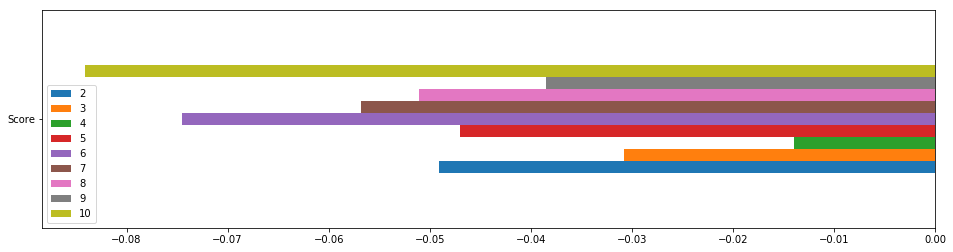

In [17]:
silhouette_scores_matrix.plot(kind = "barh",figsize=(16,4))

### Result

In [24]:
sample_preds

array([0, 1, 1, 0, 1, 1, 2, 0, 0, 1])

In [19]:
clrs = []
for item in preds:
    if item ==0:
        clrs.append('red')
    elif item ==1:
        clrs.append('blue')
    elif item ==2:
        clrs.append('green')
        

### Severity sclae is : 0,1,2

In [20]:
resultdf = train.copy(deep =True)

In [21]:
resultdf['label'] = preds

In [22]:
resultdf.head(100)

,bugID,text,label
0,1436291.0,"Context menu animation broken when ""Delete fro...",0
1,1436379.0,Links do not work when Pocket stories are upda...,1
2,1254660.0,Don't list both http and https versions of a U...,1
3,1273667.0,Simplify long-press context menu for top sites...,0
4,1299685.0,Consider replacing ActivityStream topsites' Vi...,1
5,1315197.0,Activity Stream topsites: fix default announc...,1
6,1319485.0,"Add domains table, with domain_id FK in histor...",2
7,1320803.0,Ability to store/retrieve custom name for a To...,0
8,1320806.0,Allow removing Top Sites items without removin...,0
9,1322501.0,"Asynchronously obtain, send, and store image d...",1


In [23]:
resultdf.groupby(['label']).count()

,bugID,text
label,,
0,1580,1644
1,3332,3427
2,1035,1083


----------